In [103]:
import numpy as np
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
import matplotlib.pyplot as plt
from mindspore import ms_function

In [104]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return mindspore.Tensor(input_batch), mindspore.Tensor(output_batch), \
        mindspore.Tensor(target_batch, mindspore.int32)

In [105]:
class Attention(nn.Cell):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Dense(n_hidden, n_hidden)
        self.out = nn.Dense(n_hidden * 2, n_class)

    def construct(self, enc_inputs, dec_inputs):
        enc_inputs = enc_inputs.swapaxes(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.swapaxes(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = []

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].expand_dims(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = ops.matmul(attn_weights, enc_outputs.swapaxes(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            out = self.out(ops.concat((dec_output, context), 1))
            model.append(out)
        
        model = ops.stack(model)

        # make model shape [n_step, n_class]
        return model.swapaxes(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = ops.zeros(n_step, mindspore.float32)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return ops.Softmax()(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return mnp.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar valuek

In [106]:
n_step = 5 # number of cells(= number of Step)
n_hidden = 128 # number of hidden units in one cell

sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

In [107]:
model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.001)

[WARNING] ME(258161:139710830719232,MainProcess):2022-08-12-21:41:32.952.304 [mindspore/nn/layer/rnns.py:392] dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
[WARNING] ME(258161:139710830719232,MainProcess):2022-08-12-21:41:32.961.000 [mindspore/nn/layer/rnns.py:392] dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


In [108]:
input_batch, output_batch, target_batch = make_batch()

In [109]:
def forward(enc_input, dec_input, target):
    output, attn = model(enc_input, dec_input)
    loss = criterion(output, target.squeeze(0))
    return loss, attn

In [110]:
grad_fn = ops.value_and_grad(forward, None, optimizer.parameters, has_aux=True)

In [111]:
@ms_function
def train_step(enc_input, dec_input, target):
    (loss, _), grads = grad_fn(enc_input, dec_input, target)
    optimizer(grads)
    return loss

In [112]:
# Train
for epoch in range(2000):
    loss = train_step(input_batch, output_batch, target_batch)
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss.asnumpy()))

Epoch: 0400 cost = 0.000808
Epoch: 0800 cost = 0.000266
Epoch: 1200 cost = 0.000135
Epoch: 1600 cost = 0.000080
Epoch: 2000 cost = 0.000053


In [113]:
# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = mindspore.Tensor(test_batch)
predict, trained_attn = model(input_batch, test_batch)
predict = predict.argmax(1)
print(sentences[0], '->', [number_dict[int(n.asnumpy())] for n in predict])

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


/home/lvyufeng/miniconda3/envs/ms1.8/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/home/lvyufeng/miniconda3/envs/ms1.8/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


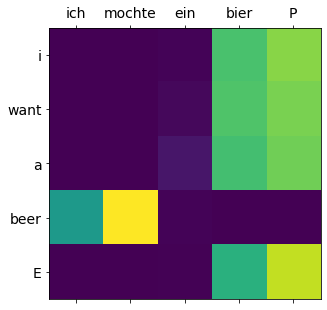

In [114]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow([attn.asnumpy() for attn in trained_attn], cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()